# Advantage Actor Critic for Wazuhl Environment

In this notebook we implement A2C algorithm for Wazuhl Environment.

In [1]:
import logging
logging.getLogger().setLevel(logging.WARNING)

In [2]:
import random
import gym
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from wutils import get_possible_actions

In [4]:
from models.a2c import ActorCritic

In [5]:
env = gym.make('wazuhl_gym:wazuhl-v0')

In [6]:
actions = get_possible_actions(env)

In [7]:
actions = actions + ["terminal"] # we need this for A2C

In [8]:
import sys
import torch
import gym
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd

class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, vocab, hidden_size=128, learning_rate=3e-4):
        super(ActorCritic, self).__init__()

        self.num_actions = num_actions
        self.hid_size = hidden_size
        self.emb_size = hidden_size // 2
        self.voc_len = len(vocab)

        self.critic_embedding = nn.Embedding(
            num_embeddings=self.voc_len,
            embedding_dim=self.emb_size,
            padding_idx=0)
        self.critic_lstm = nn.LSTM(self.emb_size, self.hid_size, batch_first=True)
        self.critic_linear1 = nn.Linear(self.hid_size, self.hid_size // 2)
        self.critic_linear2 = nn.Linear(self.hid_size // 2, 1)

        self.actor_embedding = nn.Embedding(
            num_embeddings=self.voc_len,
            embedding_dim=self.emb_size,
            padding_idx=0)
        self.actor_lstm = nn.LSTM(self.emb_size, self.hid_size, batch_first=True)
        self.actor_linear1 = nn.Linear(self.hid_size, self.hid_size // 2)
        self.actor_linear2 = nn.Linear(self.hid_size // 2, num_actions)

    def forward(self, state):
        self.hidden_actor = (torch.randn(1, 1, self.hid_size), torch.randn(1, 1, self.hid_size))
        self.hidden_critic = (torch.randn(1, 1, self.hid_size), torch.randn(1, 1, self.hid_size))

        value = self.critic_embedding(state)
        value, self.hidden_critic = self.critic_lstm(value, self.hidden_critic)
        value = value[:, -1, :]
        value = F.relu(self.critic_linear1(value))
        value = self.critic_linear2(value)

        policy_dist = self.actor_embedding(state)
        policy_dist, self.hidden_actor = self.actor_lstm(policy_dist, self.hidden_actor)
        policy_dist = policy_dist[:, -1, :]
        policy_dist = F.relu(self.actor_linear1(policy_dist))
        policy_dist = F.softmax(self.actor_linear2(policy_dist), dim=1)

        return value, policy_dist

Apply Actor-Critic for Wazuhl environment:

In [9]:
import logging
logging.getLogger().setLevel(logging.WARNING)

In [10]:
max_episodes = 5000
num_steps = 30

In [11]:
#compile time, exec time, test_name
def get_reward(times):
    if times[1] == 0:
        return 0
    return -times[1] + 10

In [12]:
from IPython.display import clear_output

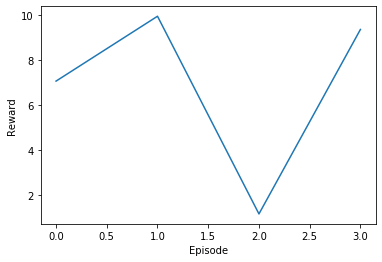

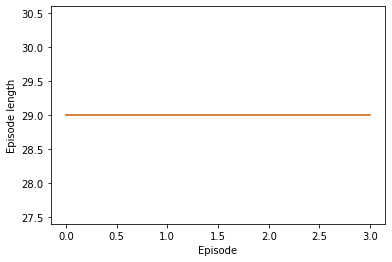

Start episode


In [ ]:
GAMMA = .95

num_inputs = len(actions)
num_outputs = env.action_space.n
   
actor_critic = ActorCritic(num_inputs, num_outputs, actions)
ac_optimizer = optim.Adam(actor_critic.parameters(), lr=1e-4)

all_lengths = []
average_lengths = []
all_rewards = []
entropy_term = 0

for episode in range(max_episodes):
    log_probs = []
    values = []
    rewards = []

    state, reward, done, _ = env.reset()
    print("Start episode")
    for steps in range(num_steps):
        #print(steps)
        value, policy_dist = actor_critic(torch.tensor(state, dtype=torch.long).view(1, len(state)))
        value = value.detach().numpy()[0,0]
        dist = policy_dist.detach().numpy() 

        action = np.random.choice(num_outputs, p=np.squeeze(dist))
        log_prob = torch.log(policy_dist.squeeze(0)[action])
        entropy = -np.sum(np.mean(dist) * np.log(dist))
        new_state, reward, done, _ = env.step(action)

        rewards.append(get_reward(reward))
        values.append(value)
        log_probs.append(log_prob)
        entropy_term += entropy
        state = new_state
            
        if steps == num_steps - 1:
            print("step limit")
            value, policy_dist = actor_critic(torch.tensor(state, dtype=torch.long).view(1, len(state)))
            value = value.detach().numpy()[0,0]
            dist = policy_dist.detach().numpy() 
            new_state, reward, done, _ = env.step_name("terminal")
            rewards.append(get_reward(reward))
            values.append(value)
            log_probs.append(log_prob)
            entropy = -np.sum(np.mean(dist) * np.log(dist))
            entropy_term += entropy
            state = new_state
            print(done)
        
        if done:
            Qval, _ = actor_critic(torch.tensor(new_state, dtype=torch.long).view(1, len(new_state)))
            Qval = Qval.detach().numpy()[0,0]
            all_rewards.append(np.sum(rewards))
            all_lengths.append(steps)
            average_lengths.append(np.mean(all_lengths[-10:]))
            if episode % 10 == 0:                    
                print("episode: {}, reward: {}, total length: {}, average length: {} \n".format(episode, np.sum(rewards), steps, average_lengths[-1]))
            break
        
    # compute Q values
    Qvals = np.zeros_like(values)
    for t in reversed(range(len(rewards))):
        Qval = rewards[t] + GAMMA * Qval
        Qvals[t] = Qval
  
    #update actor critic
    values = torch.FloatTensor(values)
    Qvals = torch.FloatTensor(Qvals)
    log_probs = torch.stack(log_probs)
        
    advantage = Qvals - values
    actor_loss = (-log_probs * advantage).mean()
    critic_loss = 0.5 * advantage.pow(2).mean()
    ac_loss = actor_loss + critic_loss + 0.001 * entropy_term

    ac_optimizer.zero_grad()
    ac_loss.backward()
    ac_optimizer.step()

    clear_output()

    smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
    smoothed_rewards = [elem for elem in smoothed_rewards]
    plt.plot(all_rewards)
    plt.plot(smoothed_rewards)
    plt.plot()
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()

    plt.plot(all_lengths)
    plt.plot(average_lengths)
    plt.xlabel('Episode')
    plt.ylabel('Episode length')
    plt.show()